# Frauduent Job Listings Identification 👾

Analytical Model to empower LinkedIn to identify potential fraudulent job listings and review/remove the potentially fraudulent job listings.

<br />

**Goal:**
- To obtain the best model that automatically identify fraudulent job listings based on NLP generated lemmas with >80% accuracy rate

**Dataset:**
- fake_job_postings_model.csv

====================

**Models:**
- Logistic Regression




**References:**
- https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
- https://www.kaggle.com/code/madz2000/text-classification-using-keras-nb-97-accuracy
- https://rishabh20118.medium.com/fake-job-posting-detection-and-getting-useful-job-posting-insights-from-the-dataset-e8edf1870831
- https://towardsdatascience.com/fake-job-predictor-a168a315d866

## 1. Pre-modelling preparations

- Install dependencies
- Import libraries and dataset
- Train-test split + Vectorization + SMOTE
- Evaluation metrics

### 1.1 Install dependencies, import libraries and dataset

**(a) Install dependencies**

In [3]:
# install dependencies
# Run the following code in your terminal if you don't have the dependecy installed:
    # pip install -U imbalanced-learn --user
    # pip install statsmodels
    # pip install -U scikit-learn
    # pip install keras
    # python -m pip install "tensorflow<2.11"

# Or run in notebook:    
# %pip install -U imbalanced-learn
# %pip install statsmodels
# %pip install -U scikit-learn
# %pip install keras

**(b) Import libraries**

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# model-related libraries
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

**(c) Import dataset**

In [2]:
# import personal_key_indicator dataset
# note: dataset is already OneHotEncoded and Integer Encoded in 'data-cleaning-preprocessing.ipynb'
job_model_df = pd.read_csv('datasets/fake_job_postings_model.csv')
job_model_df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,character_count,word_count,sentence_count,lemma,processed_text
0,0,1,0,0,2720,411,7,"['Marketing', 'Intern', 'US', 'NY', 'New', 'Yo...",Marketing Intern US NY New York Marketing Food...
1,0,1,0,0,6227,944,25,"['Customer', 'Service', 'Cloud', 'Video', 'Pro...",Customer Service Cloud Video Production NZ Auc...
2,0,1,0,0,2662,387,8,"['Commissioning', 'Machinery', 'Assistant', 'C...",Commissioning Machinery Assistant CMA US IA We...
3,0,1,0,0,5558,752,9,"['Account', 'Executive', 'Washington', 'DC', '...",Account Executive Washington DC US DC Washingt...
4,0,1,1,0,4060,510,16,"['Bill', 'Review', 'Manager', 'US', 'FL', 'For...",Bill Review Manager US FL Fort Worth SpotSourc...


### 1.2 Train-Test Split + Vectorization + SMOTE (Synthetic Minority Oversampling Technique)

#### 1.2.1 Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(job_model_df["processed_text"], job_model_df["fraudulent"], test_size=0.3, random_state=0)

#### 1.2.2 Vectorization

The process to convert text data into numerical data/vector, is called vectorization or in the NLP world, word embedding

Bag-of-Words(BoW) is a well-known method for converting text data to numerical data:

1. `Count vectors`: It builds a vocabulary from a corpus of documents and counts how many times the words appear in each document

2. `Term Frequency-Inverse Document Frequencies (tf-Idf)`: Count vectors might not be the best representation for converting text data to numerical data. So, instead of simple counting, we can also use an advanced variant of the Bag-of-Words that uses the term frequency–inverse document frequency (or Tf-Idf). Basically, the value of a word increases proportionally to count in the document, but it is inversely proportional to the frequency of the word in the corpus

**Differences:**
CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach), while TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

**(a) Count Vectorization**

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

print('X_train_cv:', X_train_cv.shape)
print('X_test_cv:', X_test_cv.shape)

X_train_cv: (12516, 1474550)
X_test_cv: (5364, 1474550)


**(b) tf-Idf Vectorization**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv=TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))

X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

print('Tfidf_train:', X_train_tv.shape)
print('Tfidf_test:', X_test_tv.shape)

Tfidf_train: (12516, 1474550)
Tfidf_test: (5364, 1474550)


#### 1.2.3 SMOTE (Synthetic Minority Oversampling Technique)

As revealed in the during the EDA stage, the distribution of the response variable `fraudulent` is highly `unbalanced`: 95.16% of rows being non-fraudulent, and 4.84% of rows being fraudulent. Therefore, the trainset needs to be `oversampled` to ensure an even distribution of the values of `fraudulent` before commencing model training.

##### 1.2.3 (a) Function to view distribution of response variable

In [6]:
def viewResponseVariableDistribution(X, y, title):
  print(title)

  number_of_HD_non_fraudulent = len(y[y == 0])
  number_of_fraudulent = len(y[y == 1])
  number_of_rows = X.shape[0]

  print("Total number of rows:", number_of_rows)
  print("Number of fraudulent == 0 rows:", number_of_HD_non_fraudulent)
  print("Number of fraudulent == 1 rows:", number_of_fraudulent)

  print("Proportion of fraudulent == 0:", number_of_HD_non_fraudulent/number_of_rows)
  print("Proportion of fraudulent == 1:", number_of_fraudulent/number_of_rows)

##### 1.2.3 (b) Oversampling (for Count Vectorized)

In [7]:
viewResponseVariableDistribution(X_train_cv, y_train, "===== Original trainset =====")

===== Original trainset =====
Total number of rows: 12516
Number of fraudulent == 0 rows: 11877
Number of fraudulent == 1 rows: 639
Proportion of fraudulent == 0: 0.9489453499520614
Proportion of fraudulent == 1: 0.05105465004793864


In [8]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X_train_cv_os, y_train_cv_os = os.fit_resample(X_train_cv, y_train)

In [9]:
viewResponseVariableDistribution(X_train_cv_os, y_train_cv_os, "===== Oversampled trainset =====")

===== Oversampled trainset =====
Total number of rows: 23754
Number of fraudulent == 0 rows: 11877
Number of fraudulent == 1 rows: 11877
Proportion of fraudulent == 0: 0.5
Proportion of fraudulent == 1: 0.5


##### 1.2.3 (c) Oversampling (for tf-ldf Vectorized)

In [10]:
viewResponseVariableDistribution(X_train_tv, y_train, "===== Original trainset =====")

===== Original trainset =====
Total number of rows: 12516
Number of fraudulent == 0 rows: 11877
Number of fraudulent == 1 rows: 639
Proportion of fraudulent == 0: 0.9489453499520614
Proportion of fraudulent == 1: 0.05105465004793864


In [11]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X_train_tv_os, y_train_tv_os = os.fit_resample(X_train_tv, y_train)

In [12]:
viewResponseVariableDistribution(X_train_tv_os, y_train_tv_os, "===== Oversampled trainset =====")

===== Oversampled trainset =====
Total number of rows: 23754
Number of fraudulent == 0 rows: 11877
Number of fraudulent == 1 rows: 11877
Proportion of fraudulent == 0: 0.5
Proportion of fraudulent == 1: 0.5


### 1.3 Evaluation Metrics

**To measure model performance, the following evaluation metrics are employed:**
- Classification Accuracy
- Confusion Matrix
- True Positive Rate, True Negative Rate, False Positive Rate, and False Negative Rate
- Precision, Recall, and F-score
- ROC AUC Score
- Out-of-bag (oob) score (for random forest)

**The main evaluation criteria will be:**
- `Classfication Accuracy`
- `False Negative Rate`

**References:**
- https://github.com/ztjhz/SC1015-Project/blob/main/Anime/classification.ipynb (done by Jing Qiang from SC1015 module)
- https://github.com/xJQx/bc2406-project/blob/main/stage2-modelling.ipynb (done by Jing Qiang from BC2406 module)

**1.3 (a) Confusion Matrix + TPR, TNR, FPR, FNR**

In [31]:
# Confusion Matrix + TPR, TNR, FPR, FNR
def confusion_matrix_TPR_TNR(y, y_pred, score, train_test_string):
    from sklearn.metrics import confusion_matrix
    
    # Confusion Matrix
    c_matrix = confusion_matrix(y, y_pred)

    # True Negatives, False Positives, False Negatives, True Positives
    TN, FP, FN, TP = c_matrix.ravel()

    # True Positive Rate, True Negative Rate, False Positive Rate, False Negative Rate
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    FPR = FP/(TN+FP)
    FNR = FN/(TP+FN)

    # Check the Goodness of Fit (on Train Data)
    print(f"Goodness of Fit of Model ({train_test_string} Dataset)")
    print("Classification Accuracy:", score)
    print("True Positive Rate:", TPR)
    print("True Negative Rate:", TNR)
    print("False Postive Rate:", FPR)
    print("False Negative Rate:", FNR)

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 8))
    sb.heatmap(c_matrix, 
               annot = True, 
               fmt=".0f", 
               annot_kws={"size": 18}).set(title=f"Confusion Matrix ({train_test_string} Dataset)")
    print()

**1.3 (b) ROC AUC Score**

In [33]:
# ROC AUC Curve score
def ROC_AUC(classifier_model, X_train, y_train, train_test):
    try:
        # getting the probabilities of our predictions
        y_scores = classifier_model.predict_proba(X_train)
        y_scores = y_scores[:,1]

        from sklearn.metrics import roc_curve
        # compute true positive rate and false positive rate
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

        # plotting them against each other
        def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
            plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
            plt.plot([0, 1], [0, 1], 'r', linewidth=4)
            plt.axis([0, 1, 0, 1])
            plt.xlabel('False Positive Rate (FPR)', fontsize=16)
            plt.ylabel('True Positive Rate (TPR)', fontsize=16)
            plt.title(f'{train_test} Dataset')

        plt.figure(figsize=(14, 7))
        plot_roc_curve(false_positive_rate, true_positive_rate)
        plt.show()


        # ROC AUC Score
        from sklearn.metrics import roc_auc_score
        r_a_score = roc_auc_score(y_train, y_scores)
        print("ROC-AUC-Score:", r_a_score)
    except:
        pass

**1.3 (c) oob score**

- For random forest

In [16]:
# Out-of-bag (oob) score
def get_oob_score(random_forest):
    print("oob score:", round(random_forest.oob_score_ * 100, 2), "%")

**1.3 (d) Function that evaluates a classifier model's performance based on various metrics**
- Classification Accuracy
- Precision, Recall, and F-score

In [47]:
def model_performance(classifier_model, X_test, y_test):
    # y_train_pred = classifier_model.predict(X_train)
    y_test_pred = classifier_model.predict(X_test)
    
    # train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    
    # Performance metrics
    # print("-> Train Dataset")
    # print("Accuracy score:", train_score)
    # print(classification_report(y_train, y_train_pred))
    # confusion_matrix_TPR_TNR(y_train, y_train_pred, train_score, "Train")

    print("-> Test Dataset")
    print("Accuracy score:", test_score)
    print(classification_report(y_test, y_test_pred))
    confusion_matrix_TPR_TNR(y_test, y_test_pred, test_score, "Test")
    ROC_AUC(classifier_model, X_test, y_test, "Test")
    print('-----\n')
    
    try:
        get_oob_score(classifier_model)
    except:
        pass

## 2) Multinomial Naive Bayes Classifier👍🏻

**Reference:**
- https://www.kaggle.com/code/madz2000/text-classification-using-keras-nb-97-accuracy

### 2.1 Fitting model with X_train_cv_os (Count Vectorization + Over Sampling)

In [45]:
from sklearn.naive_bayes import MultinomialNB

# training the model
mnb_cv = MultinomialNB()

# fitting the nb for bag of words
mnb_cv.fit(X_train_cv_os, y_train_cv_os)

# Predicting the model for bag of words
y_test_cv_predict = mnb_cv.predict(X_test_cv)

# Accuracy score for bag of words
mnb_cv_score = accuracy_score(y_test, y_test_cv_predict)
print("accuracy score:", mnb_cv_score)

accuracy score: 0.8957867263236391


-> Test Dataset
Accuracy score: 0.8957867263236391
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      5137
           1       0.25      0.73      0.37       227

    accuracy                           0.90      5364
   macro avg       0.62      0.82      0.66      5364
weighted avg       0.96      0.90      0.92      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8957867263236391
True Positive Rate: 0.7268722466960352
True Negative Rate: 0.9032509246642009
False Postive Rate: 0.0967490753357991
False Negative Rate: 0.27312775330396477



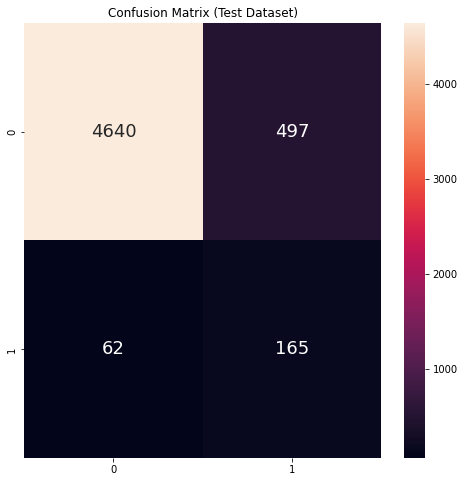

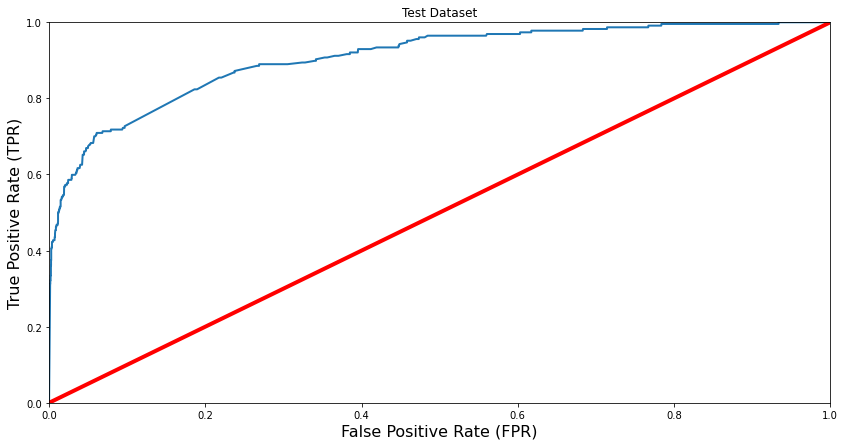

ROC-AUC-Score: 0.9064204668728814
-----



In [48]:
model_performance(mnb_cv, X_test_cv, y_test)

### 2.2 Fitting model with X_train_tfldf_os (tf-ldf Vectorization + Over Sampling)👍🏻

In [49]:
from sklearn.naive_bayes import MultinomialNB

# training the model
mnb_tv = MultinomialNB()

# fitting the nb for bag of words
mnb_tv.fit(X_train_tv_os, y_train_tv_os)

# Predicting the model for bag of words
y_test_tv_predict = mnb_tv.predict(X_test_tv)

# Accuracy score for bag of words
mnb_tv_score = accuracy_score(y_test, y_test_tv_predict)
print("accuracy score:", mnb_tv_score)

accuracy score: 0.8998881431767338


-> Test Dataset
Accuracy score: 0.8998881431767338
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5137
           1       0.26      0.74      0.38       227

    accuracy                           0.90      5364
   macro avg       0.62      0.82      0.66      5364
weighted avg       0.96      0.90      0.92      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8998881431767338
True Positive Rate: 0.73568281938326
True Negative Rate: 0.9071442476153397
False Postive Rate: 0.0928557523846603
False Negative Rate: 0.2643171806167401



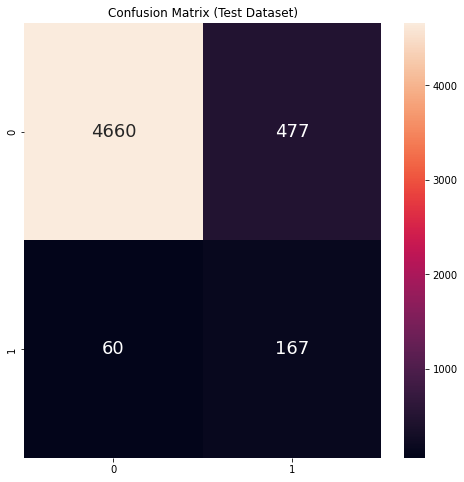

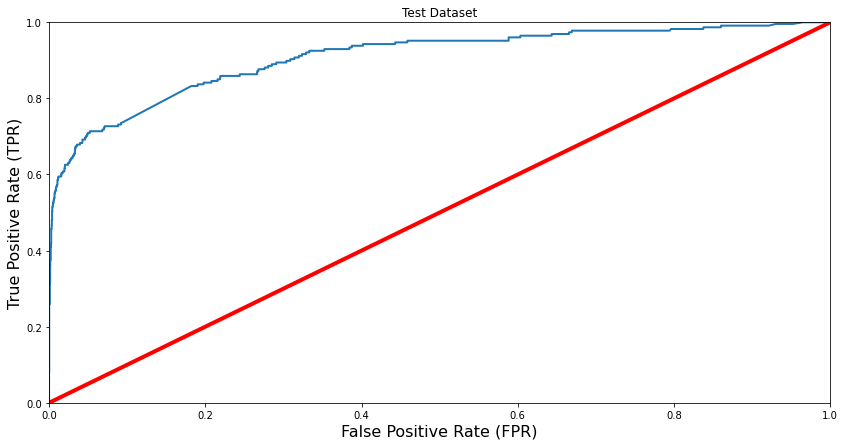

ROC-AUC-Score: 0.9084374482784052
-----



In [54]:
model_performance(mnb_tv, X_test_tv, y_test)

## 3) Neural Network (keras)

Please install tensorflow if you do not have it.
- https://www.tensorflow.org/install/pip
- https://bobbyhadz.com/blog/python-no-module-named-tensorflow

**Note:**
- Neural Network is not runned due to lack of memory to handle large text data

In [27]:
import keras
from keras.layers import Dense
from keras.models import Sequential

In [28]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = X_train_cv.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               147455100 
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 10)                260       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 147,461,696
Trainable params: 147,461,696
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Not enough memory to convert X_train_cv to array format to fit the model
# model.fit(X_train_cv.toarray(), y_train, epochs=5)

## 4) Random Forest ❌

In [66]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest_m1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
random_forest_m1.fit(X_train_cv_os, y_train_cv_os)

RandomForestClassifier(oob_score=True, random_state=42)

-> Test Dataset
Accuracy score: 0.26043997017151377
              precision    recall  f1-score   support

           0       1.00      0.23      0.37      5137
           1       0.05      0.99      0.10       227

    accuracy                           0.26      5364
   macro avg       0.53      0.61      0.24      5364
weighted avg       0.96      0.26      0.36      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.26043997017151377
True Positive Rate: 0.9911894273127754
True Negative Rate: 0.2281487249367335
False Postive Rate: 0.7718512750632665
False Negative Rate: 0.00881057268722467



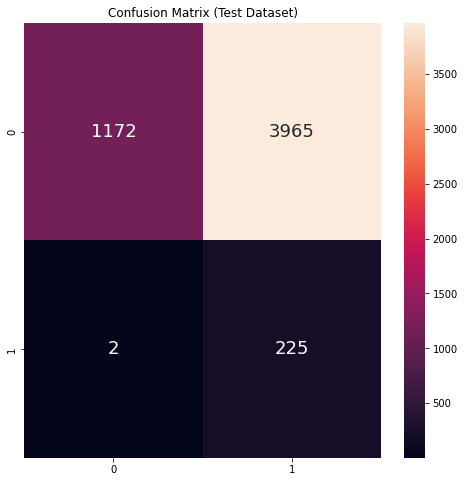

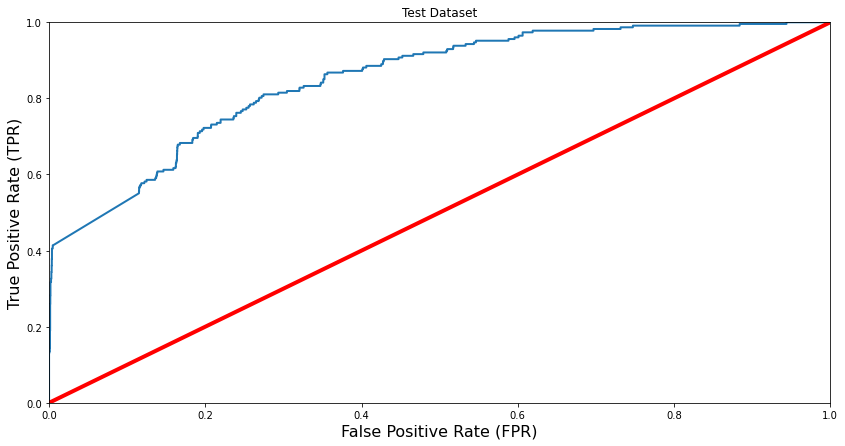

ROC-AUC-Score: 0.851106123922583
-----

oob score: 50.0 %


In [67]:
model_performance(random_forest_m1, X_test_cv, y_test)

## 5) Support Vector Classifier ❌

https://siberian.dev/nlp/text-classification-using-svc-and-count-vectorizer/code

### 5.1 Fitting model with X_train_cv_os (Count Vectorization + Over Sampling)

In [52]:
from sklearn.svm import SVC
svc_cv = SVC(random_state=0)
svc_cv.fit(X_train_cv_os, y_train_cv_os)

SVC(random_state=0)

-> Test Dataset
Accuracy score: 0.6152125279642058
              precision    recall  f1-score   support

           0       0.97      0.62      0.75      5137
           1       0.06      0.54      0.11       227

    accuracy                           0.62      5364
   macro avg       0.51      0.58      0.43      5364
weighted avg       0.93      0.62      0.73      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.6152125279642058
True Positive Rate: 0.5374449339207048
True Negative Rate: 0.6186490169359549
False Postive Rate: 0.38135098306404513
False Negative Rate: 0.46255506607929514

-----



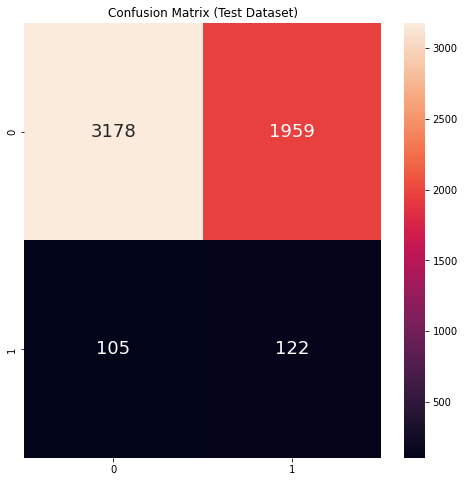

In [55]:
model_performance(svc_cv, X_test_cv, y_test)

### 5.2 Fitting model with X_train_tv_os (Count Vectorization + Over Sampling)

In [61]:
from sklearn.svm import SVC
svc_tv = SVC(random_state=0)
svc_tv.fit(X_train_tv_os, y_train_tv_os)

SVC(random_state=0)

-> Test Dataset
Accuracy score: 0.8849739000745712
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5137
           1       0.13      0.31      0.18       227

    accuracy                           0.88      5364
   macro avg       0.55      0.61      0.56      5364
weighted avg       0.93      0.88      0.91      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8849739000745712
True Positive Rate: 0.30837004405286345
True Negative Rate: 0.9104535721238076
False Postive Rate: 0.08954642787619232
False Negative Rate: 0.6916299559471366

-----



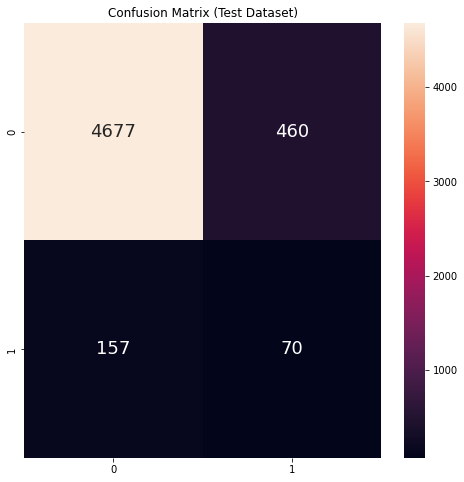

In [127]:
model_performance(svc_tv, X_test_tv, y_test)

## 6) Logistic Regression ❌

### 6.1 Fitting model with X_train_cv_os (Count Vectorization + Over Sampling)

In [57]:
from sklearn.linear_model import LogisticRegression

log_reg_cv = LogisticRegression()
log_reg_cv.fit(X_train_cv_os, y_train_cv_os)

LogisticRegression()

-> Test Dataset
Accuracy score: 0.46140939597315433
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      5137
           1       0.07      0.96      0.13       227

    accuracy                           0.46      5364
   macro avg       0.53      0.70      0.37      5364
weighted avg       0.96      0.46      0.59      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.46140939597315433
True Positive Rate: 0.960352422907489
True Negative Rate: 0.43936149503601324
False Postive Rate: 0.5606385049639868
False Negative Rate: 0.039647577092511016



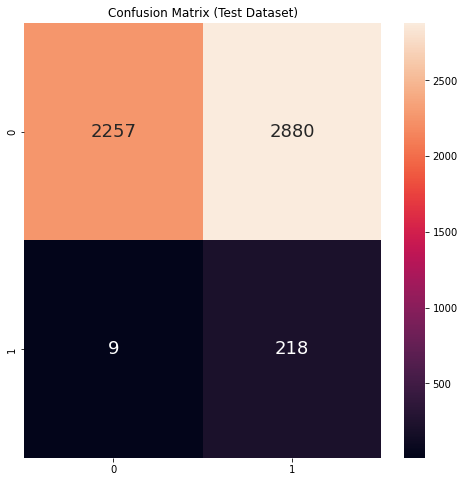

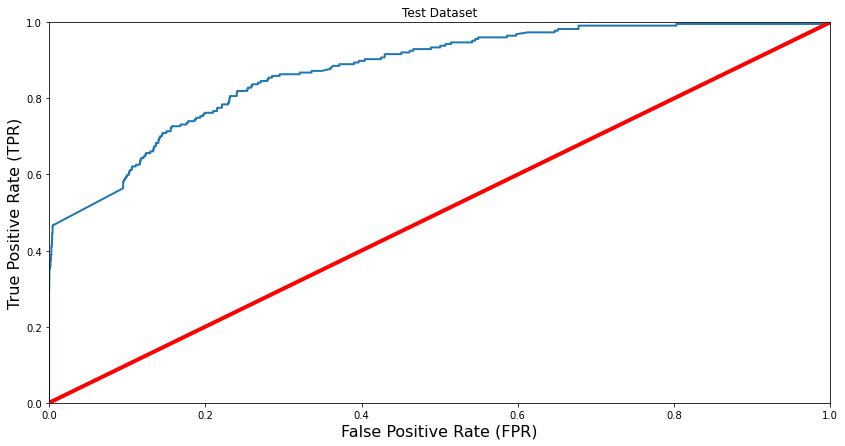

ROC-AUC-Score: 0.873551044979886
-----



In [58]:
model_performance(log_reg_cv, X_test_cv, y_test)

### 6.2 Fitting model with X_train_tv_os (Count Vectorization + Over Sampling)

In [59]:
from sklearn.linear_model import LogisticRegression

log_reg_tv = LogisticRegression()
log_reg_tv.fit(X_train_tv_os, y_train_tv_os)

LogisticRegression()

-> Test Dataset
Accuracy score: 0.9725950782997763
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5137
           1       0.82      0.45      0.58       227

    accuracy                           0.97      5364
   macro avg       0.90      0.72      0.78      5364
weighted avg       0.97      0.97      0.97      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.9725950782997763
True Positive Rate: 0.44933920704845814
True Negative Rate: 0.9957173447537473
False Postive Rate: 0.004282655246252677
False Negative Rate: 0.5506607929515418



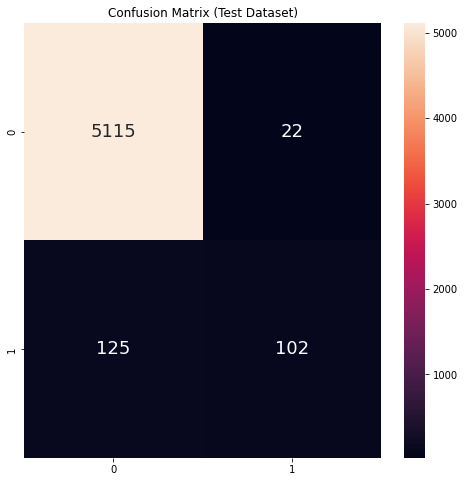

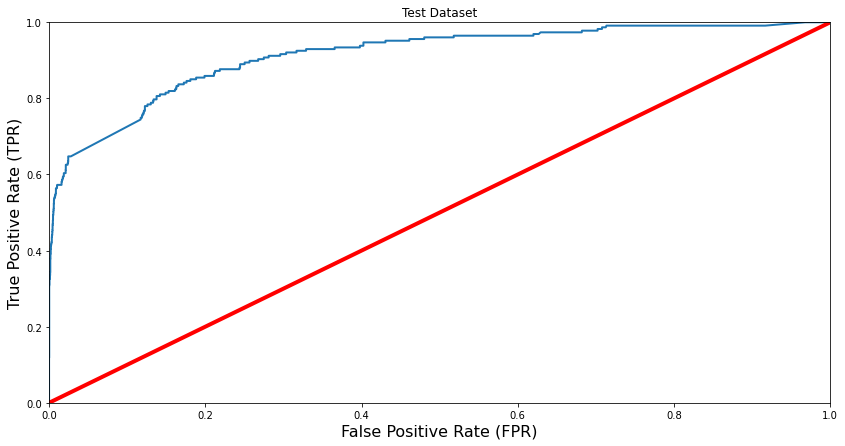

ROC-AUC-Score: 0.9139729988620177
-----



In [60]:
model_performance(log_reg_tv, X_test_tv, y_test)

## 7) Best Model
`Multinomial Naive Bayes Classifier` with `tf-ldf vectorization` is the best model

### 7.1 Model Comparison

**The main evaluation criteria are:**
- High `Classfication Accuracy`
  - Ensures that the predictions are accurate in general.
- Low `False Negative Rate`
  - Ensures that fraudulent job listings do not get away undetected.



In [133]:
results = {
    "Model": [
        "Multinomial Naive Bayes Classifier (TV)", 
        "Multinomial Naive Bayes Classifier (CV)", 
        "Logistic Regression (TV)", 
        "Logistic Regression (CV)",
        "SVC (TV)",
        "SVC (CV)",
        "Random Forest (CV)"
    ],
    "Classification Accuracy": [
        0.8999, 
        0.8958, 
        0.9726, 
        0.4614, 
        0.8850, 
        0.6152, 
        0.2604
    ],
    "False Negative Rate": [
        0.2643, 
        0.2731, 
        0.5507, 
        0.0396, 
        0.6916, 
        0.4626, 
        0.0088
    ]
}

results_table = pd.DataFrame(results)
results_table

,Model,Classification Accuracy,False Negative Rate
0,Multinomial Naive Bayes Classifier (TV),0.8999,0.2643
1,Multinomial Naive Bayes Classifier (CV),0.8958,0.2731
2,Logistic Regression (TV),0.9726,0.5507
3,Logistic Regression (CV),0.4614,0.0396
4,SVC (TV),0.8850,0.6916
5,SVC (CV),0.6152,0.4626
6,Random Forest (CV),0.2604,0.0088


**Conclusion:**
- `Multinomial Naive Bayes Classifier` with `tf-ldf vectorization` is the best model as it has a very high classification accuracy (~90%) and relatively low false negative rate (~26%)
- The `Logistic Regression (TV)` and `SVC (TV)` models are not selected even though they have a high classification accuracy (more than 85%) is because they have high false negative rates (more than 50%)
- The `Logistic (CV)` and `Random Forest (CV)` models are not selected even though they have a very low false negative rate (less than 5%) is because they have low classficiation accuracies (less than 50%)


### 7.2 Performance Results of Best Model

-> Test Dataset
Accuracy score: 0.8998881431767338
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5137
           1       0.26      0.74      0.38       227

    accuracy                           0.90      5364
   macro avg       0.62      0.82      0.66      5364
weighted avg       0.96      0.90      0.92      5364

Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8998881431767338
True Positive Rate: 0.73568281938326
True Negative Rate: 0.9071442476153397
False Postive Rate: 0.0928557523846603
False Negative Rate: 0.2643171806167401



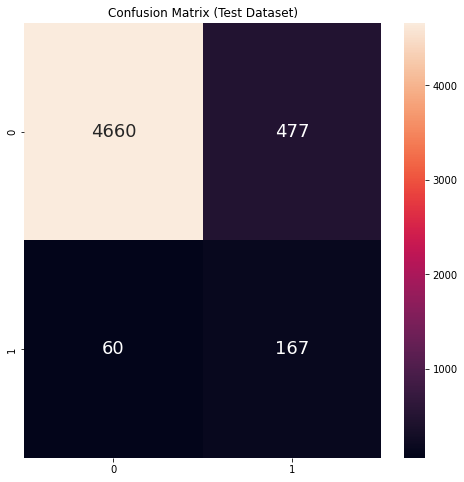

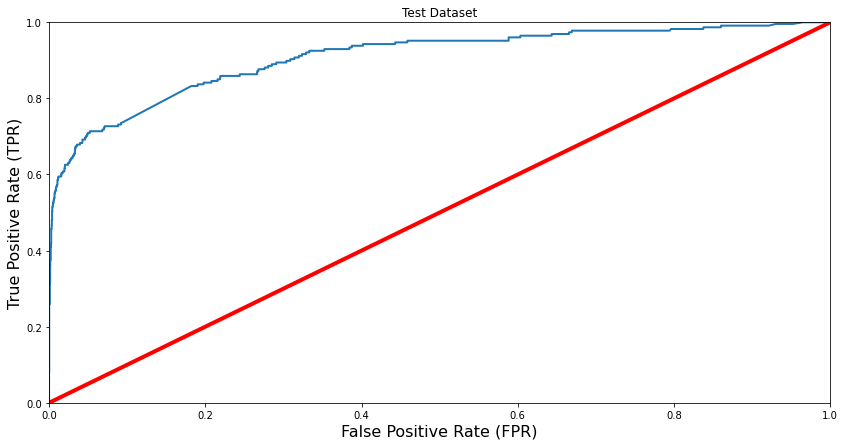

ROC-AUC-Score: 0.9084374482784052
-----



In [134]:
model_performance(mnb_tv, X_test_tv, y_test)

### 7.3 Exporting Best Model

**7.3 (a) Export**

In [69]:
# Save Model Using joblib
import joblib

# save the models to disk
filename = 'models/mnb_tv.sav'
joblib.dump(mnb_tv, filename)

['models/mnb_tv.sav']

In [140]:
import joblib

filename = 'models/tf-idf_vectorizer.sav'
joblib.dump(tv, filename)

['models/tf-idf_vectorizer.sav']

In [136]:
# Save Model Using joblib
import joblib

# def mnb_tv_model(text_data):
#     # tv.transform() does not take string input
#     if type(text_data) == str:
#         text_data = [text_data]
        
#     text_data_tv = tv.transform(text_data)
    
#     return "Fraudulent" if mnb_tv.predict(text_data_tv)[0] else "Real"

# save the models to disk
filename = 'models/mnb_tv_model.sav'
joblib.dump(mnb_tv, filename)

['models/mnb_tv_model.sav']

**7.3 (b) How to Import**

In [3]:
# Sourced From LinkedIn - For testing purposes only
text_data_random = """Works is an AI-driven Web3 work platform that enables companies to hire the world's best software developers and designers remotely and on demand. We use Web3 to reward our community and incentivise network growth.

The ideal candidate will be responsible for developing high-quality applications. They will also be responsible for designing and implementing testable and scalable code.

Responsibilities

Write high quality, testable, reusable, maintainable code both in frontend and backend
Develop and maintain backend components and services
Design products that can work seamlessly across multiple platforms and browsers
Write high quality, testable, reusable, maintainable code
Develop and maintain backend components and services
Participate in code review and design review
Provide task analysis, estimation, and potential blockers
Write various API’s and backend business processing logic with the cutting edge NodeJs language to improve the availability, scalability, latency, and efficiency of Works’ range of services
Build a high-performance dynamic web application with Angular

Qualifications

3+ years experience in software development, and 2+ years of experience working in product development as an Software Engineer or equivalent
Commanding grasp of Angular, Node.js, Python, MongoDB
Well-versed in standard web frameworks such as Angular, React.js
Proficient in at least one programming language and the fundamentals of CS such as Data Structures, Algorithms, Operating Systems, etc.
Proficiency in OOP, SQL, Design Patterns, and software best practices
Working knowledge of building back-end systems around DBMS, Caches, NoSQL, Web, and App servers.
Experience in Payments, Transaction History and Wallet System is a plus
Experience in building cloud service would be an advantage
Strong knowledge of best coding practices, centralised repository version contract and deployment procedures"""

In [4]:
# some time later...

# Import
import joblib
from models.execute_tv_model import execute_tv_model

# load the model from disk
loaded_mnb_tv_model = joblib.load('models/mnb_tv_model.sav')
tfidf_vectorizer = joblib.load('models/tf-idf_vectorizer.sav')

# Input text data
text_data_real = job_model_df["processed_text"][0]
text_data_fraudulent = job_model_df["processed_text"][7]

# Execute the model
prediction_real = execute_tv_model(text_data_real, loaded_mnb_tv_model, tfidf_vectorizer)
prediction_fraudulent = execute_tv_model(text_data_fraudulent, loaded_mnb_tv_model, tfidf_vectorizer)
prediction_random_text = execute_tv_model(text_data_random, loaded_mnb_tv_model, tfidf_vectorizer)

# Print Results
print("----- Prediction 1 -----")
print("Input text data:", text_data_real)
print("Prediction:", prediction_real)

print("")

print("----- Prediction 2 -----")
print("Input text data:", text_data_fraudulent)
print("Prediction:", prediction_fraudulent)

print("")

print("----- Prediction 3 -----")
print("Input text data:", text_data_random)
print("Prediction:", prediction_random_text)

----- Prediction 1 -----
Input text data: Marketing Intern US NY New York Marketing Food52 create groundbreaking award win cook site support connect celebrate home cook give everything need one place top editorial business engineering team focus use technology find new good way connect people around specific food interest offer superb highly curated information food cooking attract talented home cook contributor country also publish well know professional like Mario Batali Gwyneth Paltrow Danny Meyer partnership Whole Foods Market Random House Food52 name best food website James Beard Foundation IACP feature New York Times NPR Pando Daily TechCrunch Today Show locate Chelsea New York City Food52 fast grow James Beard Award win online food community crowd source curated recipe hub currently interview full part time unpaid intern work small team editor executive developer New York City headquarters Reproducing repackaging exist Food52 content number partner sit Huffington Post Yahoo Buzz

## 8) Future Improvements

- Include other predictor variables beside the `processed_text` variable during the model fitting and prediction process
  - E.g. `telecommuting`, `has_company_logo`, `has_questions`, `character_count`, `word_count`,`sentence_count`
- Hyperparameter tuning to achieve higher accuracy levels
- Try an alternative word embedding technique, `Word2Vec`, which captures semantic information